# Bernoulli GLM Flux1 Flow Example
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-amerio/GenSBI-examples/blob/main/examples/sbi-benchmarks/bernoulli_glm/flow_flux/bernoulli_glm_flow_flux.ipynb)
> Notice: This notebook has been automatically generated. If you find any errors, please [open an issue](https://github.com/aurelio-amerio/GenSBI-examples/issues) on the GenSBI-examples GitHub repository.


---
This notebook demonstrates conditional Flow Matching on the Bernoulli GLM task using JAX and Flax. 

## Table of Contents
| Section | Description |
|---|---|
| 1. Introduction & Setup | Overview, environment, device, autoreload |
| 2. Task & Data Preparation | Define task, visualize data, create datasets |
| 3. Model Configuration & Definition | Load config, set parameters, instantiate model |
| 4. Training | Train or restore model, manage checkpoints |
| 5. Evaluation & Visualization | Visualize loss, sample posterior, compute log prob |
| 6. Diagnostics | Run diagnostics (TARP, SBC, L-C2ST) |

---



## 1. Introduction & Setup <a class="anchor" id="1"></a>
---
In this section, we introduce the problem, set up the computational environment, import required libraries, configure JAX for CPU or GPU usage, and enable autoreload for iterative development. Compatibility with Google Colab is also ensured.

In [ ]:
# Check if running on Colab and install dependencies if needed
try:
    import google.colab
    colab = True
except ImportError:
    colab = False

if colab:
    # Install required packages and clone the repository
    %pip install --quiet "gensbi[cuda12] @ git+https://github.com/aurelio-amerio/GenSBI"
    %pip install --quiet "gensbi_examples @ git+https://github.com/aurelio-amerio/GenSBI-examples"
    !git clone --depth 1 https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples/sbi-benchmarks/bernoulli_glm/flow_flux

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.6/199.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.5/490.5 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 11.1 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.1/384.1 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 127.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 34.3 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.5/150.5 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
# select device

os.environ["JAX_PLATFORMS"] = "cuda" 
# os.environ["JAX_PLATFORMS"] = "cpu" 

## 2. Task & Data Preparation <a class="anchor" id="2"></a>
---
In this section, we define the Bernoulli GLM task, visualize reference samples, and create the training and validation datasets required for model learning. Batch size and sample count are set for reproducibility and performance.

In [3]:
restore_model=True
train_model=False

In [4]:
import orbax.checkpoint as ocp
# get the current notebook path
notebook_path = os.getcwd()
checkpoint_dir = os.path.join(notebook_path, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

In [5]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import nnx

from numpyro import distributions as dist
import numpy as np

In [6]:
from gensbi.utils.plotting import plot_marginals

In [8]:
from gensbi_examples.tasks import get_task
task = get_task("bernoulli_glm", kind="conditional")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


metadata.json:   0%|          | 0.00/893 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

bernoulli_glm/train-00000-of-00001.parqu(…):   0%|          | 0.00/81.3M [00:00<?, ?B/s]

bernoulli_glm/validation-00000-of-00001.(…):   0%|          | 0.00/1.18M [00:00<?, ?B/s]

bernoulli_glm/test-00000-of-00001.parque(…):   0%|          | 0.00/1.19M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

bernoulli_glm_posterior/reference_poster(…):   0%|          | 0.00/4.70M [00:00<?, ?B/s]

Generating reference_posterior split:   0%|          | 0/10 [00:00<?, ? examples/s]

In [9]:
# reference posterior for an observation
obs, reference_samples = task.get_reference(num_observation=8)

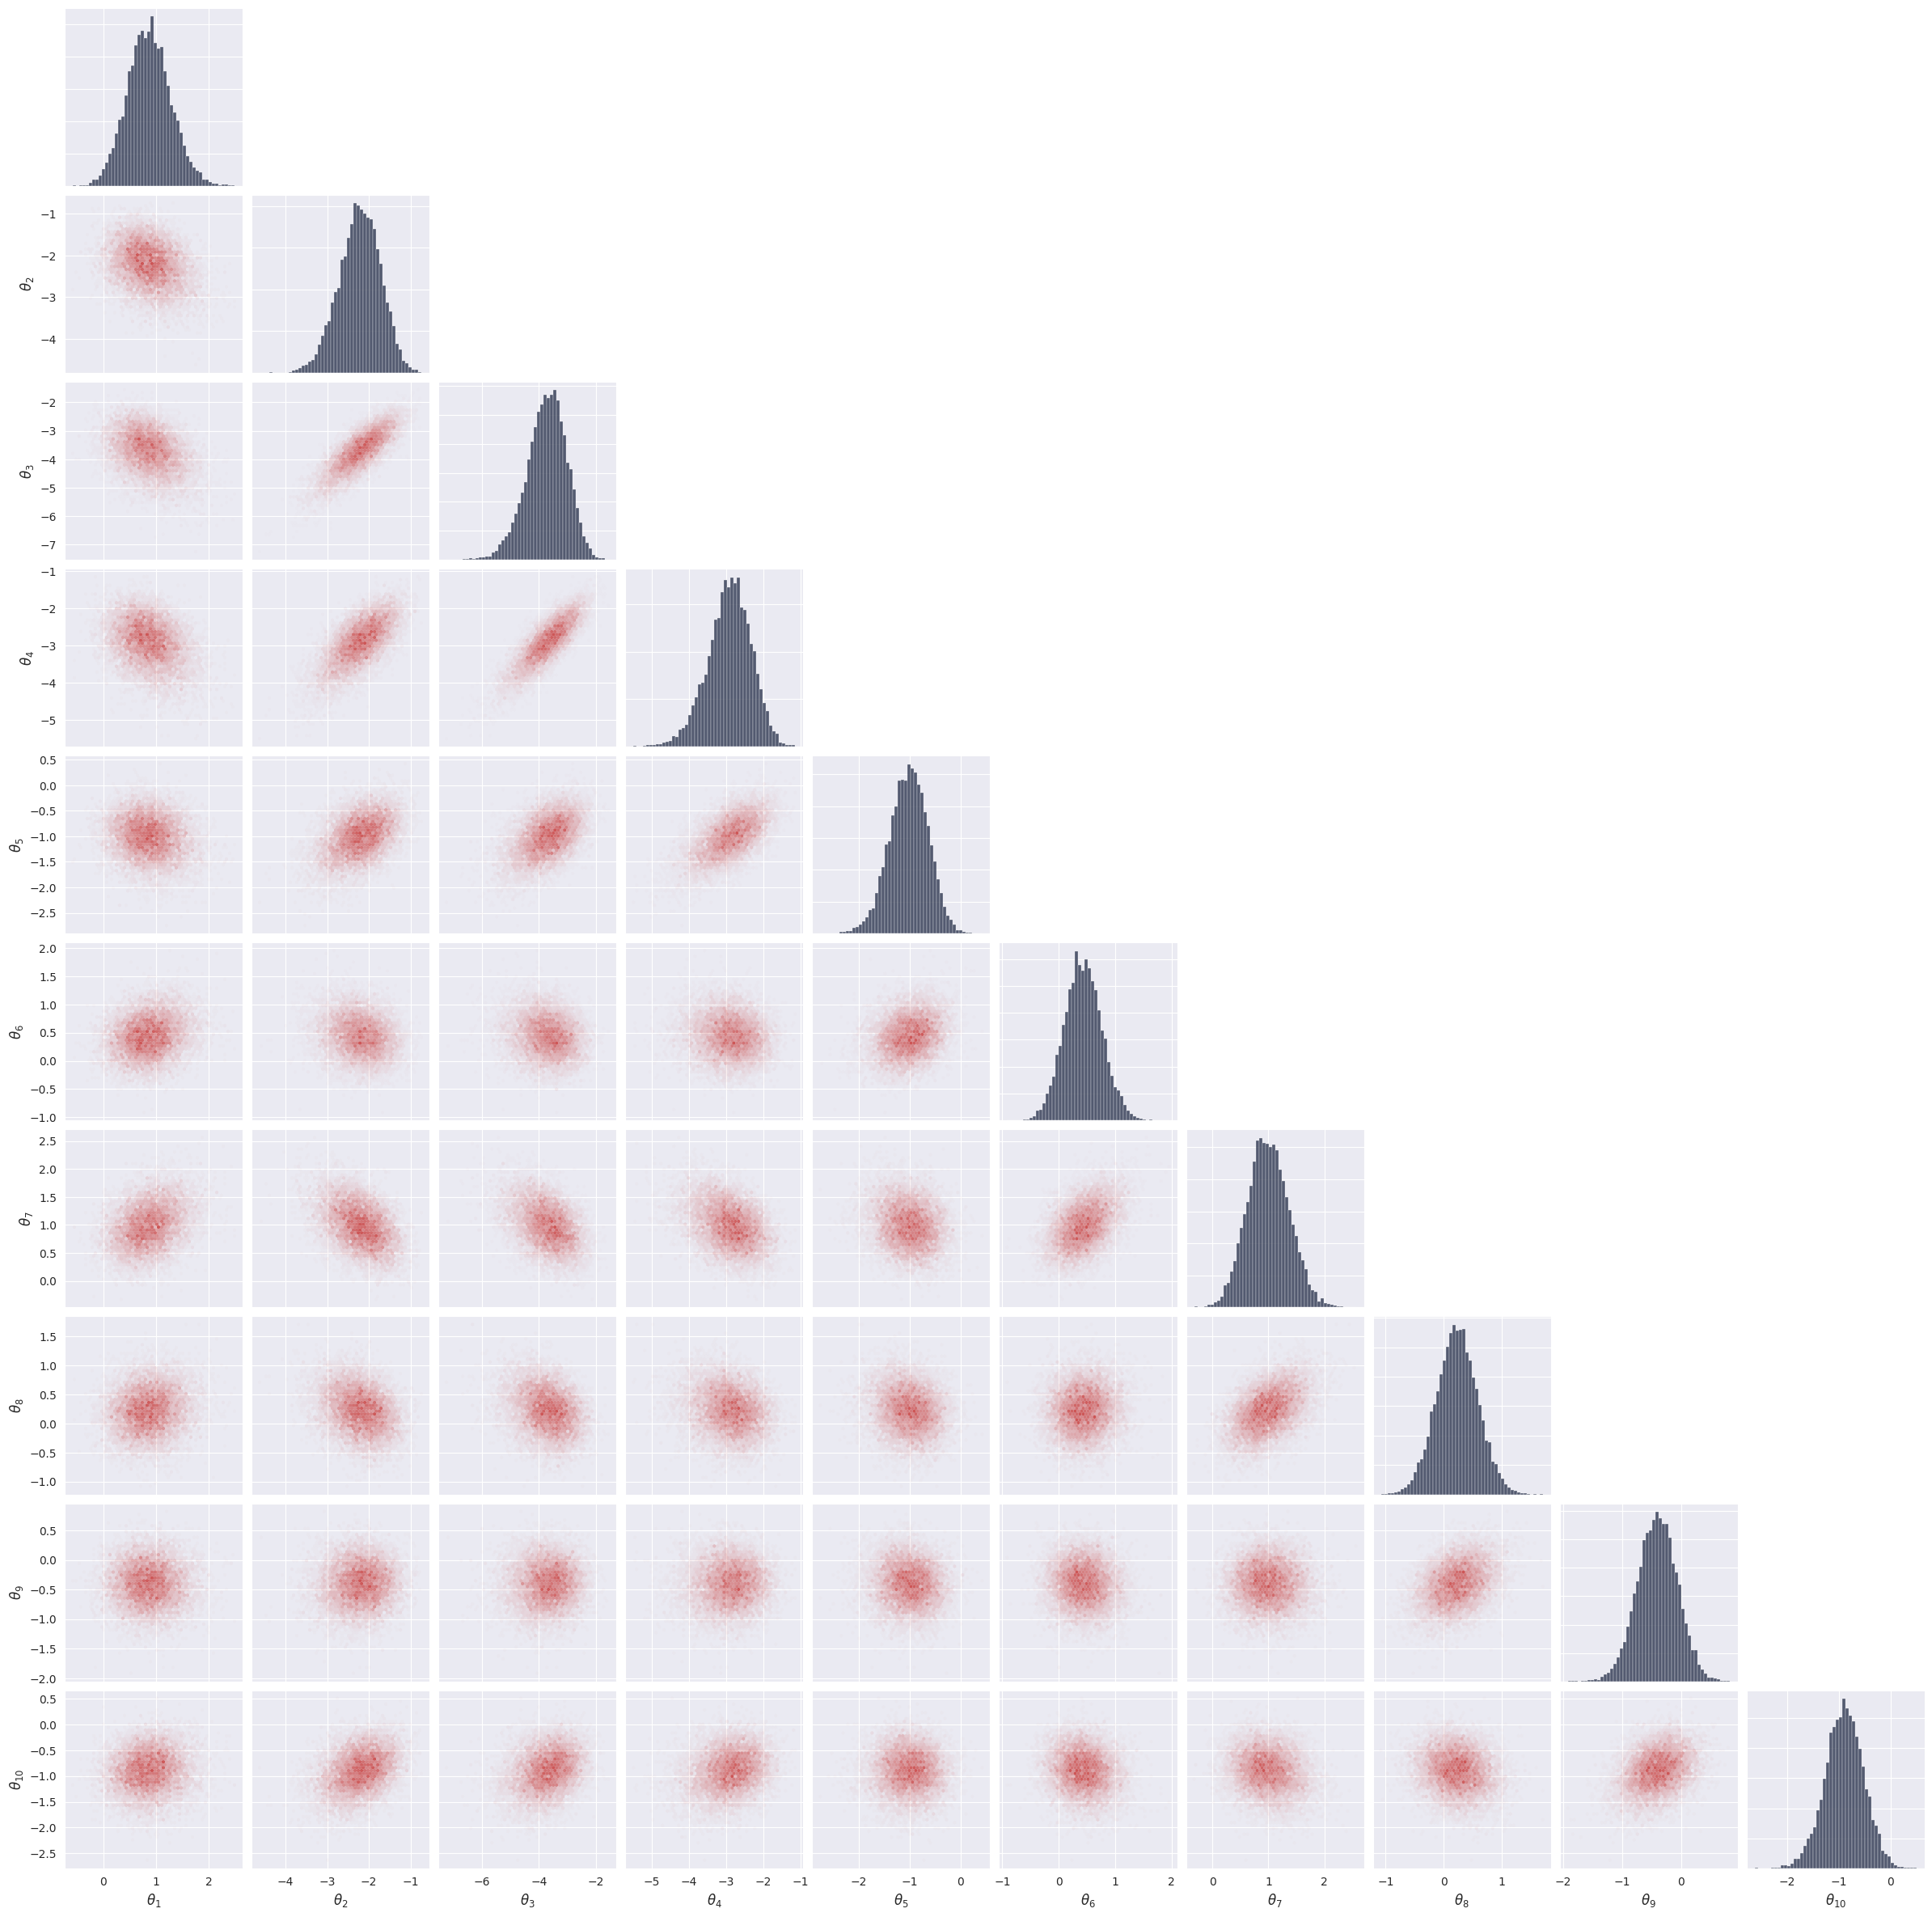

In [10]:
# plot the 2D posterior 
plot_marginals(np.asarray(reference_samples, dtype=np.float32), gridsize=50, plot_levels=False, backend="seaborn")
plt.show()

In [11]:
# make a dataset
nsamples = int(1e5)

In [12]:
# Set batch size for training. Larger batch sizes help prevent overfitting, but are limited by available GPU memory.
batch_size = 4096
# Create training and validation datasets using the Bernoulli GLM task object.
train_dataset = task.get_train_dataset(batch_size)
val_dataset = task.get_val_dataset(batch_size)

# Create iterators for the training and validation datasets.
dataset_iter = iter(train_dataset)
val_dataset_iter = iter(val_dataset)

## 3. Model Configuration & Definition <a class="anchor" id="3"></a>
---
In this section, we load the model and optimizer configuration, set all relevant parameters, and instantiate the Flux1 model. Edge masks and marginalization functions are used for flexible inference and posterior estimation.

In [13]:
from gensbi.recipes import Flux1FlowPipeline

In [14]:
import yaml

# Path to the configuration file.
config_path = f"{notebook_path}/config/config_flow_flux.yaml"

In [15]:
# Extract dimensionality information from the task object.
dim_obs = task.dim_obs  # Number of parameters to infer
dim_cond = task.dim_cond    # Number of observed data dimensions

dim_joint = task.dim_joint  # Joint dimension (for model input)

In [16]:
pipeline = Flux1FlowPipeline.init_pipeline_from_config(
        train_dataset,
        val_dataset,
        dim_obs,
        dim_cond,
        config_path,
        checkpoint_dir,
    )

## 4. Training <a class="anchor" id="4"></a>
---
In this section, we train the model or restore a checkpoint.

In [17]:
# pipeline.train(nnx.Rngs(0), save_model=False)

In [18]:
pipeline.restore_model()

Restored model from checkpoint


## 5. Evaluation & Visualization <a class="anchor" id="5"></a>
---
In this section, we evaluate the trained Simformer model by sampling from the posterior, and comparing results to reference data.

### Section 5.1: Posterior Sampling
---
In this section, we sample from the posterior distribution using the trained model and visualize the results. Posterior samples are generated for a selected observation and compared to reference samples to assess model accuracy.

In [19]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
def get_samples(idx, nsamples=10_000, use_ema=False, key=None):
    observation, reference_samples = task.get_reference(idx)
    true_param = jnp.array(task.get_true_parameters(idx))

    if key is None:
        key = jax.random.PRNGKey(42)

    time_grid = jnp.linspace(0,1,100)

    samples = pipeline.sample(key, observation, nsamples, use_ema=use_ema, time_grid=time_grid)
    return samples, true_param, reference_samples

In [20]:
samples, true_param, reference_samples =  get_samples(8)

### Section 5.2: Visualize Posterior Samples
---
In this section, we plot the posterior samples as a 2D histogram to visualize the learned distribution and compare it to the ground truth.

In [21]:
from gensbi.utils.plotting import plot_marginals, plot_2d_dist_contour

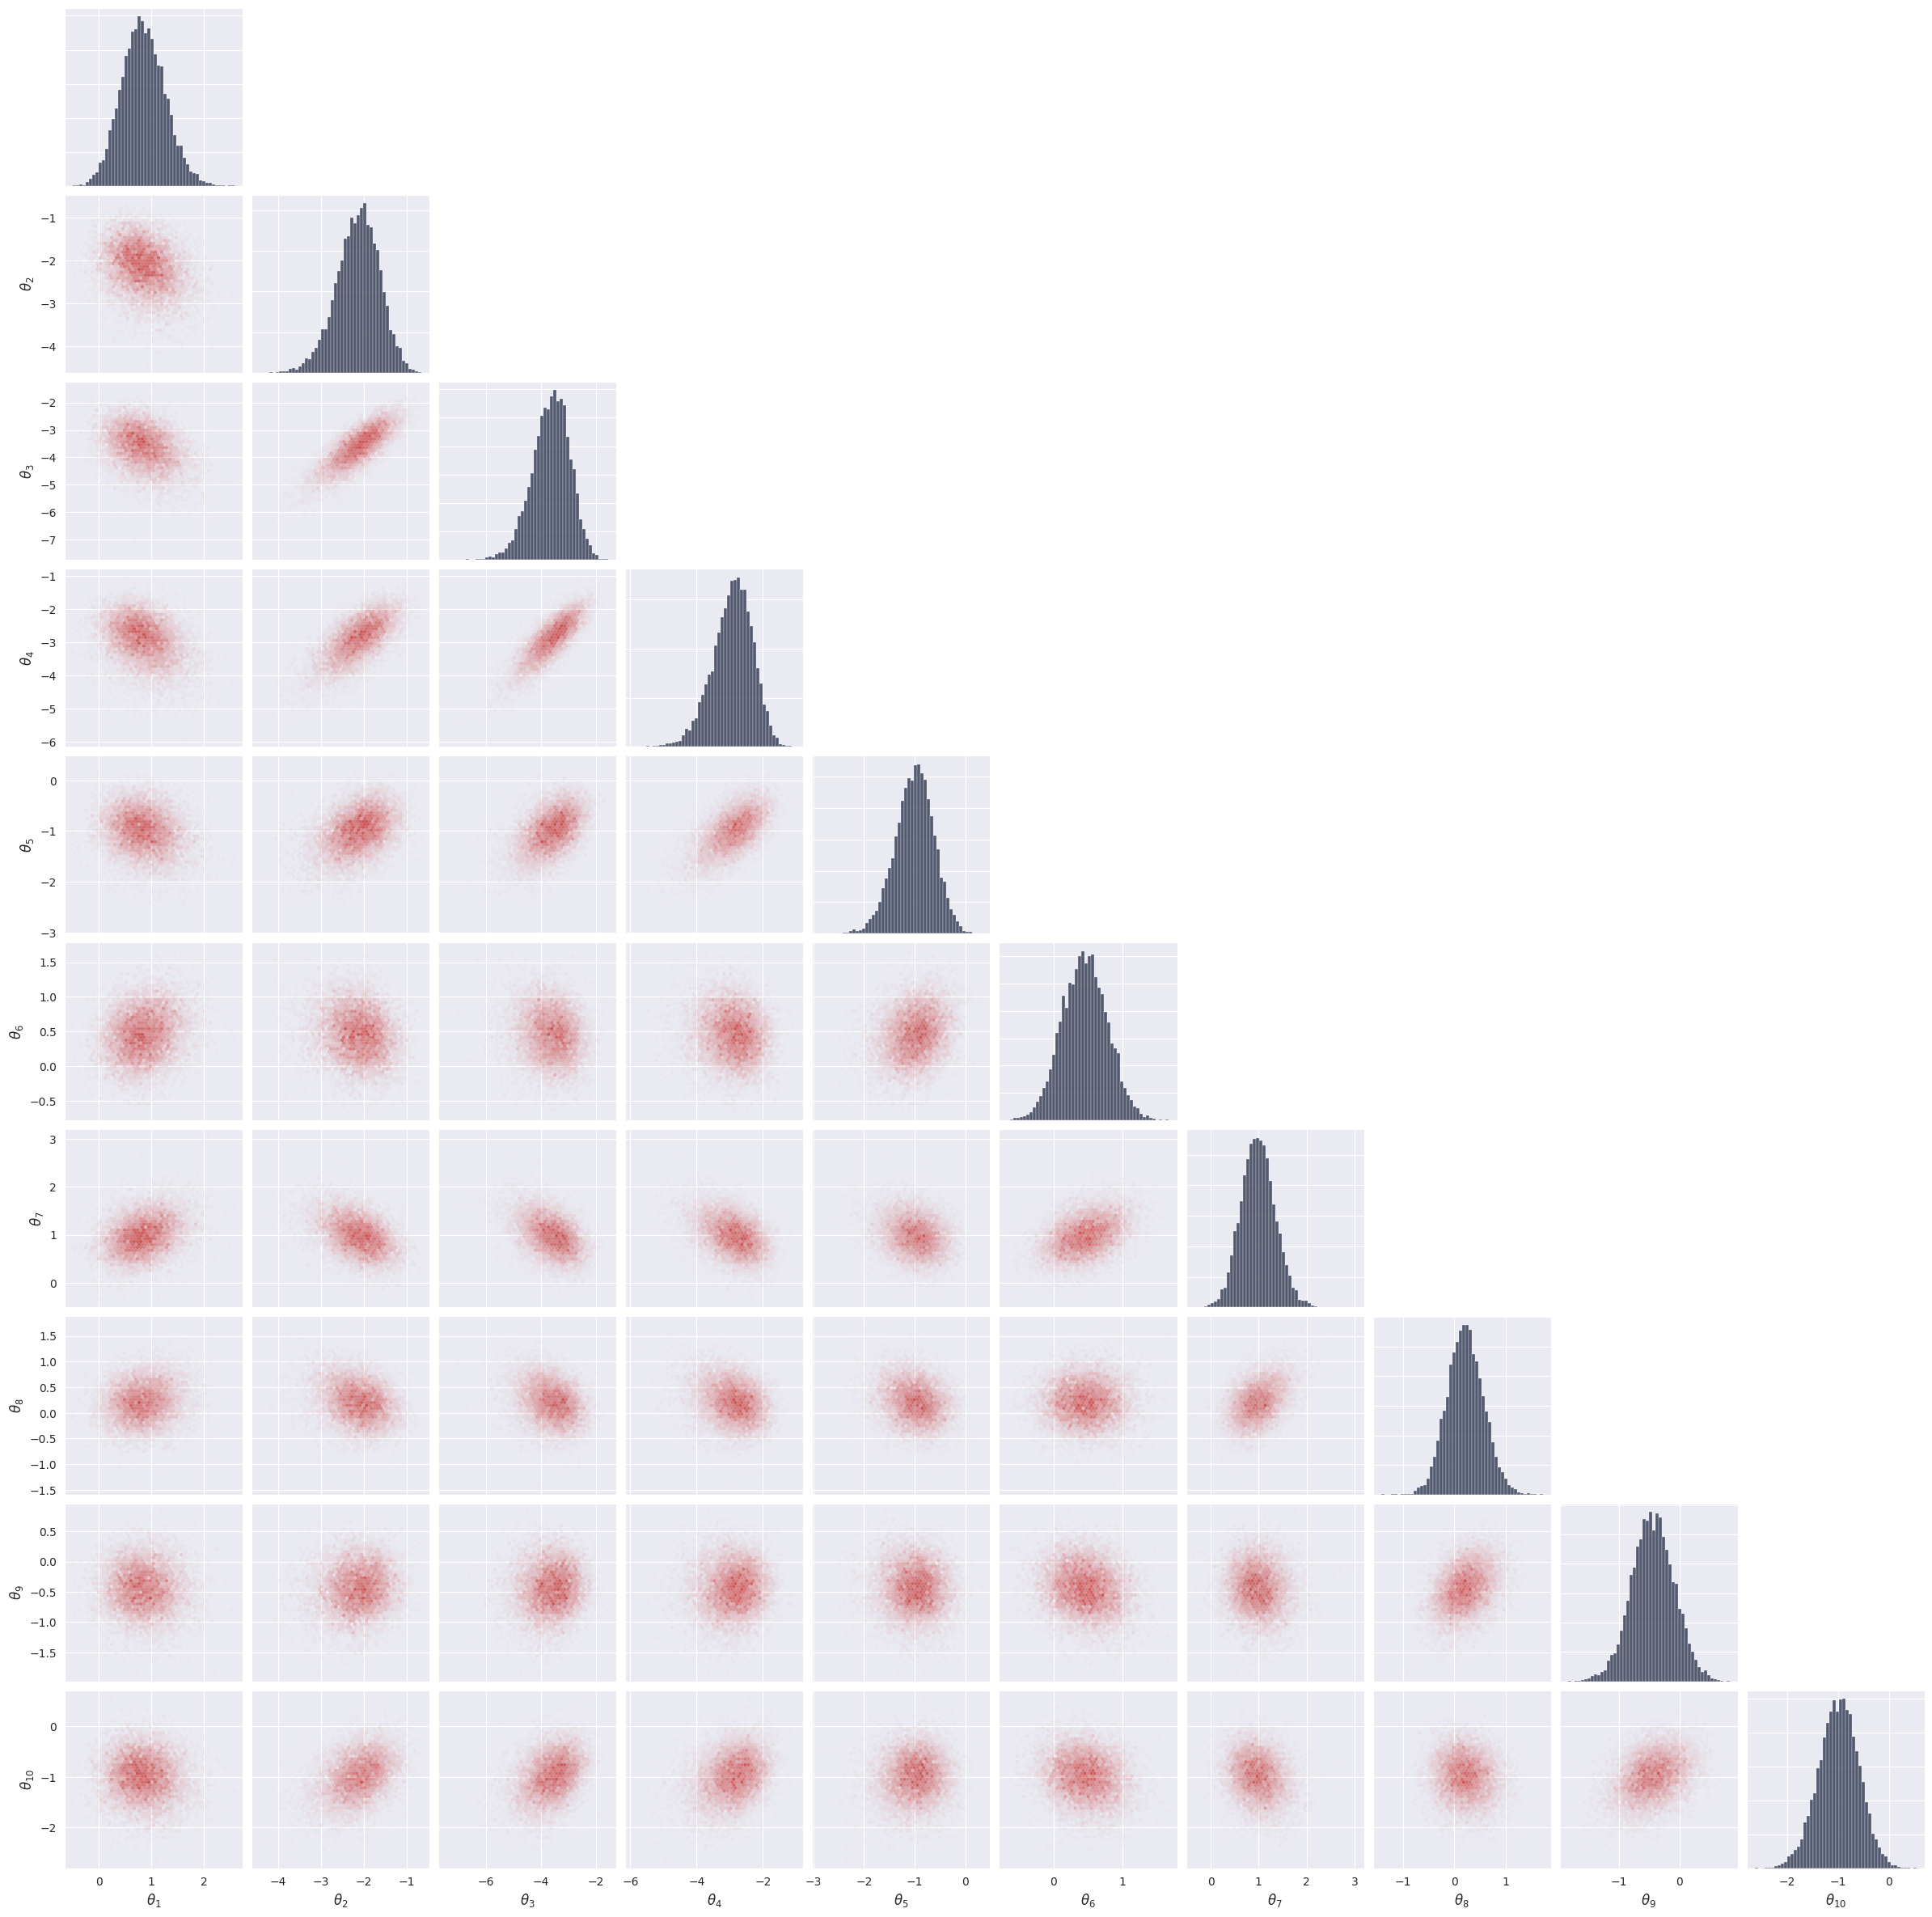

In [23]:
plot_marginals(np.array(samples[-1,...,0]), backend="seaborn", plot_levels=False, gridsize=50)
plt.show()

# alternatively use "corner" to plot containment levels too
# plot_marginals(samples[-1,...,0], backend="corner", gridsize=20)
# plt.show()

<img src="https://raw.githubusercontent.com/aurelio-amerio/GenSBI-examples/refs/heads/main/examples/sbi-benchmarks/bernoulli_glm/flow_flux/imgs/marginals_ema.png" width=800>

## 6. Diagnostics <a class="anchor" id="6"></a>

We report here the results of the posterior calibration tests. As an excercise, you can implement the tests as in the Two Moons example and compare the results. 

**Average C2ST**: 0.5527 ± 0.0152

**TARP:** <br><br>
<img src="https://raw.githubusercontent.com/aurelio-amerio/GenSBI-examples/refs/heads/main/examples/sbi-benchmarks/bernoulli_glm/flow_flux/imgs/tarp.png" width=400>

**SBC** <br><br>

<img src="https://raw.githubusercontent.com/aurelio-amerio/GenSBI-examples/refs/heads/main/examples/sbi-benchmarks/bernoulli_glm/flow_flux/imgs/sbc.png" width=800>

**L-C2ST**<br><br>
<img src="https://raw.githubusercontent.com/aurelio-amerio/GenSBI-examples/refs/heads/main/examples/sbi-benchmarks/bernoulli_glm/flow_flux/imgs/lc2st.png" width=400>